<a href="https://colab.research.google.com/github/kiplimock/colab-notebooks/blob/main/image_segmentation_using_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Segmentation with UNet Architecture

Author: [@kiplimock](https://github.com/kiplimock)

Original source: [@bnsreenu](https://github.com/bnsreenu/python_for_microscopists/blob/master/074-Defining%20U-net%20in%20Python%20using%20Keras.py)

In [50]:
import os
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from zipfile import ZipFile
from urllib.request import urlretrieve
from skimage.io import imread, imshow
from skimage.transform import resize

In [9]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [2]:
# Building the model
inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
inputs = tf.keras.layers.Lambda(lambda x: x / 255.0)(inputs)

### Contraction Path

In [3]:
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c1)
p1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c2)
p2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c3)
p3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c4)
p4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c5)

### Expansion Path

In [4]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)

In [5]:
# model output
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

### Compiling the Model

In [6]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[1][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['dropout[1][0]']             
                                                                                              

### Checkpoints and Callbacks

In [7]:
# model checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

# callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
]

### Downloading the Data

In [23]:
# download the data
def download_and_unzip(url, save_path):

  print("Downloading the data...")

  urlretrieve(url, save_path)

  # extract the files
  try:
    with ZipFile(save_path) as f:
      path = save_path.split('.')[0]
      f.extractall(path)
      os.remove(save_path)

      print('Done')
  except Exception as e:
    print("Invalid file ", e)


def extract_all(dir):
  zip_files = glob(dir + '/*.zip')
  for path in zip_files:
    try:
      with ZipFile(path) as f:
        f.extractall(path.split('.')[0])
        os.remove(path)
        print(f'Extracted {path}')

    except Exception as e:
      print("Invalid file ", e)

In [24]:
url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/8089/44321/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1704359198&Signature=McrhIPg1r%2Bp7kwzyYbR0k%2FW27ejEqAAIZwZMdzAlYvVWlm89YOXdaLoS8KnreD3CBzgN2q29HkWd1xvAABXPoA9sc99VJGo3V6aoi3Pcn2e95w09FXwBi2Pm0cvrOoMfY7lBv0zXnYq3Vn5Yk6ClyqUpOXVMMGwCGpSOV6ZOcfEPu%2FPECI44ak5o6J8UywVo2RnTn9pk5uE%2F7672ojuE0x2Xc0ImyCMbOD59eTrBurtXtg5yhc3kXGzT2URCl9ISM7k%2B1XkgkNtoxUrJ4ojCQ1y3NxXWNv%2FBfDqdv8V3h8EkXB6D3oDjBpS4Afwjv1CIoucK%2BYJIQIxnjKopGlserQ%3D%3D&response-content-disposition=attachment%3B+filename%3Ddata-science-bowl-2018.zip'
filename = 'data_science_bowl_2018.zip'

download_and_unzip(url, filename)
extract_all('data_science_bowl_2018')

Done
Extracted data_science_bowl_2018/stage1_train_labels.csv.zip
Extracted data_science_bowl_2018/stage1_solution.csv.zip
Extracted data_science_bowl_2018/stage2_sample_submission_final.csv.zip
Extracted data_science_bowl_2018/stage1_train.zip
Extracted data_science_bowl_2018/stage1_sample_submission.csv.zip
Extracted data_science_bowl_2018/stage2_test_final.zip
Extracted data_science_bowl_2018/stage1_test.zip


### Preparing the Data

In [64]:
TRAIN_PATH = '/content/data_science_bowl_2018/stage1_train'
TEST_PATH = '/content/data_science_bowl_2018/stage1_test'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

for n, id_ in tqdm(enumerate(train_ids), position=0, leave=True, total=len(train_ids)):
  path = os.path.join(TRAIN_PATH, id_)
  img = imread(os.path.join(path, 'images', f'{id_}.png'))[:, :, :IMG_CHANNELS]
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_train[n] = img

  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
  for mask_file in next(os.walk(path + '/masks/'))[2]:
    mask_ = imread(os.path.join(path, 'masks', mask_file))
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)

  Y_train[n] = mask

100%|██████████| 670/670 [05:59<00:00,  1.86it/s]


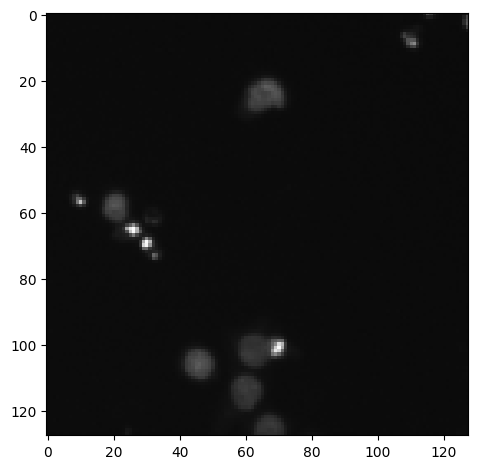

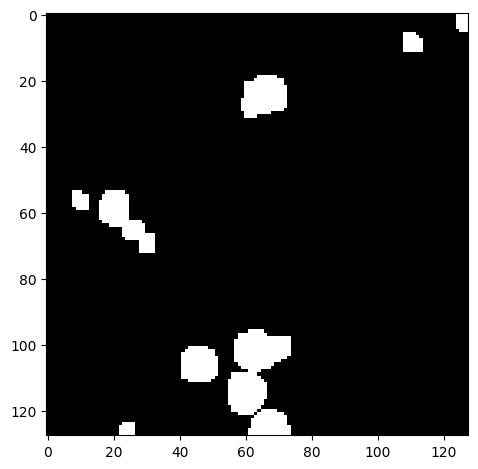

In [68]:
idx = np.random.randint(0, len(train_ids))
imshow(X_train[idx])
plt.show()
imshow(Y_train[idx])
plt.show()